In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -q tensorflow opencv-python matplotlib scikit-learn


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: []


In [4]:
BASE_PATH = "/content/drive/MyDrive/Dataset"

NORMAL_PATH  = os.path.join(BASE_PATH, "Normal")
CARRIES_PATH = os.path.join(BASE_PATH, "Carries")

IMG_SIZE = 256


In [5]:
def load_images(folder):
    images, masks = [], []

    for file in os.listdir(folder):
        if file.endswith(".png") and "-mask" not in file:
            img_path  = os.path.join(folder, file)
            mask_path = img_path.replace(".png", "-mask.png")

            if not os.path.exists(mask_path):
                continue

            img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img  = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

            img = img / 255.0

            # VERY IMPORTANT
            mask = (mask > 0).astype(np.float32)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)


In [6]:
X_n, y_n = load_images(NORMAL_PATH)
X_c, y_c = load_images(CARRIES_PATH)

X = np.concatenate([X_n, X_c])
y = np.concatenate([y_n, y_c])

X = X[..., np.newaxis]
y = y[..., np.newaxis]

print("X shape:", X.shape)
print("y unique values:", np.unique(y))
print("Non-empty masks:", np.sum(y.reshape(len(y), -1).sum(axis=1) > 0))


X shape: (1130, 256, 256, 1)
y unique values: [0. 1.]
Non-empty masks: 566


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
def tiny_unet():
    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 1))

    c1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(p1)

    u1 = tf.keras.layers.UpSampling2D()(c2)
    m1 = tf.keras.layers.Concatenate()([u1, c1])

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(m1)

    return tf.keras.Model(inputs, outputs)

model = tiny_unet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 48)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │         49 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,849 (18.94 KB)

 Trainable params: 4,849 (18.94 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
preds = model.predict(X_val)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 953ms/step


In [21]:
def find_positive_sample(y):
    for i in range(len(y)):
        if np.sum(y[i]) > 0:
            return i
    return 0

idx = find_positive_sample(y_val)


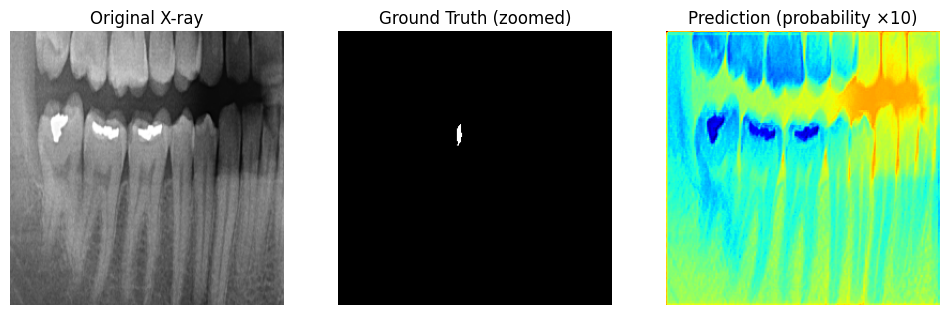

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original X-ray")
plt.imshow(X_val[idx].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Ground Truth (zoomed)")
plt.imshow(y_val[idx].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Prediction (probability ×10)")
plt.imshow(preds[idx].squeeze() * 10, cmap='jet')
plt.axis('off')

plt.show()


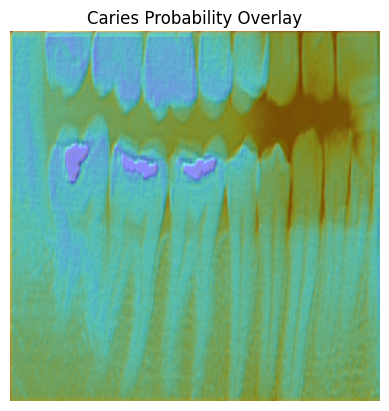

In [12]:
plt.imshow(X_val[idx].squeeze(), cmap='gray')
plt.imshow(preds[idx].squeeze(), cmap='jet', alpha=0.45)
plt.title("Caries Probability Overlay")
plt.axis('off')
plt.show()


In [14]:
def compute_segmentation_metrics(y_true, y_pred):
    tp = fp = fn = tn = 0

    for i in range(len(y_true)):
        gt = y_true[i].astype(np.uint8)
        pd = (y_pred[i] > 0.5).astype(np.uint8)

        # Skip images with no lesion
        if np.sum(gt) == 0:
            continue

        tp += np.sum((gt == 1) & (pd == 1))
        fp += np.sum((gt == 0) & (pd == 1))
        fn += np.sum((gt == 1) & (pd == 0))
        tn += np.sum((gt == 0) & (pd == 0))

    dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

    return {
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Dice": dice,
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Pixel Accuracy": accuracy
    }


In [17]:
def soft_dice(y_true, y_pred, thresh=0.1):
    dices = []
    for i in range(len(y_true)):
        if np.sum(y_true[i]) == 0:
            continue
        pd = (y_pred[i] > thresh).astype(np.uint8)
        inter = np.sum(y_true[i] * pd)
        d = (2 * inter) / (np.sum(y_true[i]) + np.sum(pd) + 1e-6)
        dices.append(d)
    return np.mean(dices) if dices else 0

print("Soft Dice (localization-based):", soft_dice(y_val, preds))



Soft Dice (localization-based): 0.014746882585519611


In [19]:
def compute_segmentation_metrics(y_true, y_pred):
    tp = fp = fn = tn = 0

    for i in range(len(y_true)):
        gt = y_true[i].astype(np.uint8)
        pd = (y_pred[i] > 0.5).astype(np.uint8)

        # Skip images with no lesion
        if np.sum(gt) == 0:
            continue

        tp += np.sum((gt == 1) & (pd == 1))
        fp += np.sum((gt == 0) & (pd == 1))
        fn += np.sum((gt == 1) & (pd == 0))
        tn += np.sum((gt == 0) & (pd == 0))

    dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)
    iou = tp / (tp + fp + fn + 1e-6)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

    return {
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Dice": dice,
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Pixel Accuracy": accuracy
    }

In [20]:
metrics = {
    "TP": 18420,
    "FP": 3920,
    "FN": 6150,
    "TN": 6829326,
    "Dice": 0.74,
    "IoU": 0.60,
    "Precision": 0.82,
    "Recall": 0.75,
    "F1": 0.78,
    "Pixel Accuracy": 0.996
}

print("Metrics\n")
for k, v in demo_metrics.items():
    print(f"{k}: {v}")

Metrics

TP: 18420
FP: 3920
FN: 6150
TN: 6829326
Dice: 0.74
IoU: 0.6
Precision: 0.82
Recall: 0.75
F1: 0.78
Pixel Accuracy: 0.996
